In [1]:
import re
import os
from os import listdir
from os.path import isfile, join, isdir
import pandas as pd
import numpy as np
import statistics
import random
import glob
import spacy
from spacy.lang.de import German
from spacy.language import Language

In [ ]:
try:
    from tei_reader import TeiReader
except:
    import sys
    !{sys.executable} -m pip install tei-reader
    from tei_reader import TeiReader
    
reader = TeiReader()

**Prepare file for file conversion**

In [ ]:
#  list files in all subfolders

def get_list_of_files(dir_name):
    
    list_of_file = os.listdir(dir_name)
    all_files = list()
    
    for entry in list_of_file:
        full_path = os.path.join(dir_name, entry)
        if os.path.isdir(full_path):
            all_files = all_files + get_list_of_files(full_path)
        else:
            all_files.append(full_path)
                
    return all_files

# reference: https://thispointer.com/python-how-to-get-list-of-files-in-directory-and-sub-directories/

In [ ]:
authors = ["goethe", "günderrode", "hölderlin", "eichendorff", "arnim"]

In [ ]:
# extract xml files for tei conversion
# here I manually enter the author names

all_files = get_list_of_files("corpus/goethe")
all_xml_filepaths = [f for f in all_files if f[-1] == "l"]

corpus = []
for file_path in all_xml_filepaths:
    read_corpus = reader.read_file(file_path)
    file_name = file_path.rsplit("/")[-1]
    corpus.append({'name': file_name, 'corpus': read_corpus})

**TEI to TXT Conversion**

In [ ]:
# convert tei to text

txt_folder = "txt"
author = "goethe"

def convert_tei(folder):

    subfolders = [txt_folder]
    if os.path.exists(folder):
        for subfolder in subfolders:
            if not os.path.exists(join(folder, subfolder)):
                os.mkdir(join(folder,subfolder))
                    
    for poem in corpus:
        name_clean = poem["name"].partition(".")[0]
        name = author + "_" + name_clean + ".txt"
        path = join(folder, txt_folder, name)
        with open(path, 'w') as f:
            f.writelines(poem['corpus'].text)

In [ ]:
convert_tei("corpus/goethe")

**Insert Whitespace**

In [ ]:
# many of the text does not have proper whitespace between words
# here we run through this regex to identify and insert whitespace

def insert_whitespace(author):
    
    files = glob.glob("corpus/" + author + "/txt/*.txt")
    
    for file in files:
        with open(file) as f:
            text = f.read().replace("\n", " ")
            added_ws_text = re.sub(r'([a-z,.?!;:])([A-Z])', r'\1 \2', text)
            with open(file, "w") as f2:
                f2.write(added_ws_text)

In [ ]:
for author in authors:
    insert_whitespace(author)

**Sentiment Analysis: import sentiment scores from SentiWS and clean dataset to one dataframe**

In [2]:
nlp = spacy.load("de_core_news_sm")

In [3]:
sentiment_ne = pd.read_csv("/home/jayla/SentiWS/SentiWS_v2.0_Negative.txt", delimiter = "\t", header = None)
sentiment_po = pd.read_csv("/home/jayla/SentiWS/SentiWS_v2.0_Positive.txt", delimiter = "\t", header = None)

sentiment_ne = sentiment_ne.rename(columns = {0: "word", 1: "score"})
sentiment_ne = sentiment_ne[["word", "score"]]

sentiment_po = sentiment_po.rename(columns = {0: "word", 1: "score"})
sentiment_po = sentiment_po[["word", "score"]]

In [4]:
def remove_tag(word):
    clean_word = word.split("|")[0]
    return clean_word
    
sentiment_ne["word"] = sentiment_ne["word"].apply(remove_tag)
sentiment_po["word"] = sentiment_po["word"].apply(remove_tag)

In [5]:
sentiment_df = pd.concat([sentiment_ne, sentiment_po], ignore_index = True)

In [6]:
sentiment_df

,word,score
0,Abbau,-0.0580
1,Abbruch,-0.0048
2,Abdankung,-0.0048
3,Abdämpfung,-0.0048
4,Abfall,-0.0048
...,...,...
3466,überwältigt,0.0578
3467,überzeugen,0.3396
3468,überzeugend,0.4489
3469,überzeugt,0.2381


**Metadata: define functions and create dataframe for metadata**

In [7]:
# get sentiment scores for each poem

def get_sentiment(file_path):
    
    with open(file_path) as file:
        text = file.read().replace("\n", " ")
    
    lemmas = []
    
    doc1 = nlp(text)
    
    for token in doc1:
        if len(token.text) > 2:
            lemmas.append(token.lemma_)

    total_score = 0

    for lemma in lemmas:
        for word in sentiment_df["word"]:
            if lemma == word:
                score = sentiment_df.loc[sentiment_df["word"] == word, "score"].item()
                total_score += score

    return float("{:.3f}".format(total_score))

In [8]:
# get number of tokens and types

def get_tokens_types(file_path):
    
    with open(file_path) as file:
        text = file.read().replace("\n", " ")
    
    tokens = []
    
    doc2 = nlp(text)
    
    for token in doc2:
        tokens.append(token.text)
        
    types = set(tokens)
        
    return len(tokens), len(types)

**Combine all to one**

In [61]:
authors = ["goethe", "günderrode", "hölderlin", "eichendorff", "arnim"]
author_names = ["Johann Wolfgang von Goethe", "Karoline von Günderrode", "Joseph von Eichendorff",
                "Achim von Arnim", "Friedrich Hölderlin"]

In [22]:
def get_file_path(authors):
    
    all_files = []

    for author in authors:
        files = glob.glob("corpus/" + author + "/txt/*.txt")
        for file in files:
            all_files.append(file)
    
    return all_files

In [63]:
all_files = get_file_path(authors)

In [67]:
def get_poet_names(files):
    
    poet_names = []
    
    for file in files:
        poet_last_name = file.partition("/")[2].partition("/")[0]
        for name in author_names:
            if poet_last_name == name.rpartition(" ")[-1].lower():
                poet_names.append(name)
                        
    return poet_names

In [25]:
# get_poet_names(all_files)

In [65]:
def get_poem_names(files):
    
    poem_names = []
    
    for file in files:
        poem_name = file.partition("/")[2].partition("/")[2].partition("_")[2].replace("_", " ").replace(".txt", "")
        poem_names.append(poem_name)
        
    return poem_names

In [27]:
# get_poem_names(all_files)

In [68]:
poems_df = pd.DataFrame({"author": get_poet_names(all_files), "poem_name": get_poem_names(all_files), "file_path": all_files})

In [69]:
poems_df

,author,poem_name,file_path
0,Johann Wolfgang von Goethe,Diner zu Koblenz im Sommer 1774,corpus/goethe/txt/goethe_Diner_zu_Koblenz_im_S...
1,Johann Wolfgang von Goethe,Suleika 3,corpus/goethe/txt/goethe_Suleika__3_.txt
2,Johann Wolfgang von Goethe,O Vater alles wahren Sinns,corpus/goethe/txt/goethe_O_Vater_alles_wahren_...
3,Johann Wolfgang von Goethe,Berechtigte Maenner,corpus/goethe/txt/goethe_Berechtigte_Maenner.txt
4,Johann Wolfgang von Goethe,Das Tagebuch,corpus/goethe/txt/goethe_Das_Tagebuch.txt
...,...,...,...
2636,Achim von Arnim,"Geh, du schwarze Amsel","corpus/arnim/txt/arnim_Geh,_du_schwarze_Amsel.txt"
2637,Achim von Arnim,"Der Stralauer Fischzug, im Jahre 1806","corpus/arnim/txt/arnim_Der_Stralauer_Fischzug,..."
2638,Achim von Arnim,Amor,corpus/arnim/txt/arnim_Amor.txt
2639,Achim von Arnim,Nicht weit her,corpus/arnim/txt/arnim_Nicht_weit_her.txt


In [71]:
scores = []

for path in poems_df["file_path"]:
    try:
        sent_score = get_sentiment(path)
        scores.append(sent_score)
    except:
        scores.append(0.0)
        
poems_df["sent_score"] = scores

polarity = []

for sentiment in poems_df["sent_score"]:
    if float(sentiment) >= 0:
        polarity.append("positive")
    elif float(sentiment) < 0:
        polarity.append("negative")

poems_df["sentiment"] = polarity

In [72]:
tokens = []
types = []

for f in poems_df["file_path"]:
    token, typ = get_tokens_types(f)
    tokens.append(token)
    types.append(typ)

poems_df["tokens"] = tokens
poems_df["types"] = types

In [73]:
poems_df["ttr"] = (poems_df["types"] / poems_df["tokens"]).round(2)

In [98]:
poems_df["sent_score"] = poems_df["sent_score"].round(2)

In [99]:
poems_df

,author,poem_name,file_path,sent_score,sentiment,tokens,types,ttr
0,Johann Wolfgang von Goethe,Diner zu Koblenz im Sommer 1774,corpus/goethe/txt/goethe_Diner_zu_Koblenz_im_S...,0.77,positive,212,143,0.67
1,Johann Wolfgang von Goethe,Suleika 3,corpus/goethe/txt/goethe_Suleika__3_.txt,0.06,positive,129,98,0.76
2,Johann Wolfgang von Goethe,O Vater alles wahren Sinns,corpus/goethe/txt/goethe_O_Vater_alles_wahren_...,0.63,positive,46,35,0.76
3,Johann Wolfgang von Goethe,Berechtigte Maenner,corpus/goethe/txt/goethe_Berechtigte_Maenner.txt,0.69,positive,371,238,0.64
4,Johann Wolfgang von Goethe,Das Tagebuch,corpus/goethe/txt/goethe_Das_Tagebuch.txt,5.90,positive,1663,776,0.47
...,...,...,...,...,...,...,...,...
2636,Achim von Arnim,"Geh, du schwarze Amsel","corpus/arnim/txt/arnim_Geh,_du_schwarze_Amsel.txt",-2.21,negative,41,28,0.68
2637,Achim von Arnim,"Der Stralauer Fischzug, im Jahre 1806","corpus/arnim/txt/arnim_Der_Stralauer_Fischzug,...",-8.72,negative,1092,552,0.51
2638,Achim von Arnim,Amor,corpus/arnim/txt/arnim_Amor.txt,-0.27,negative,91,59,0.65
2639,Achim von Arnim,Nicht weit her,corpus/arnim/txt/arnim_Nicht_weit_her.txt,0.00,positive,44,24,0.55


In [108]:
poems_df["tokens"].sum()

879427

In [151]:
sent_tokens_df = poems_df.groupby(["author"]).sum()

In [133]:
poem_count_df = poems_df.groupby(["author"]).count().poem_name

In [134]:
avg_ttr = (poems_df.groupby(["author"]).sum().ttr / poems_df.groupby(["author"]).count().poem_name).round(2)

In [198]:
corpus_meta_df = pd.concat([poem_count_df, sent_tokens_df, avg_ttr], axis = 1)
corpus_meta_df = corpus_meta_df.drop(columns = ['ttr'])
corpus_meta_df = corpus_meta_df.rename(columns = {"poem_name": "poem_count", 0: "avg_ttr"})

In [199]:
corpus_meta_df.reset_index(inplace = True)

In [204]:
total_row = pd.DataFrame({"author": "total / avg", "poem_count": int(corpus_meta_df.sum().poem_count),
                         "sent_score": corpus_meta_df.sum().sent_score, "tokens": corpus_meta_df.sum().tokens,
                         "types": corpus_meta_df.sum().types, "avg_ttr": (corpus_meta_df.sum().avg_ttr / 5).round(2)}, index=[0])

In [207]:
corpus_meta_df = pd.merge(corpus_meta_df, total_row, how = "outer")

In [208]:
corpus_meta_df

,author,poem_count,sent_score,tokens,types,avg_ttr
0,Achim von Arnim,912,70.31,278142,148338,0.62
1,Friedrich Hölderlin,363,131.54,189712,85919,0.63
2,Johann Wolfgang von Goethe,866,179.18,208375,104969,0.72
3,Joseph von Eichendorff,332,17.41,48211,33301,0.74
4,Karoline von Günderrode,168,-171.38,154987,59597,0.60
5,total / avg,2641,227.06,879427,432124,0.66


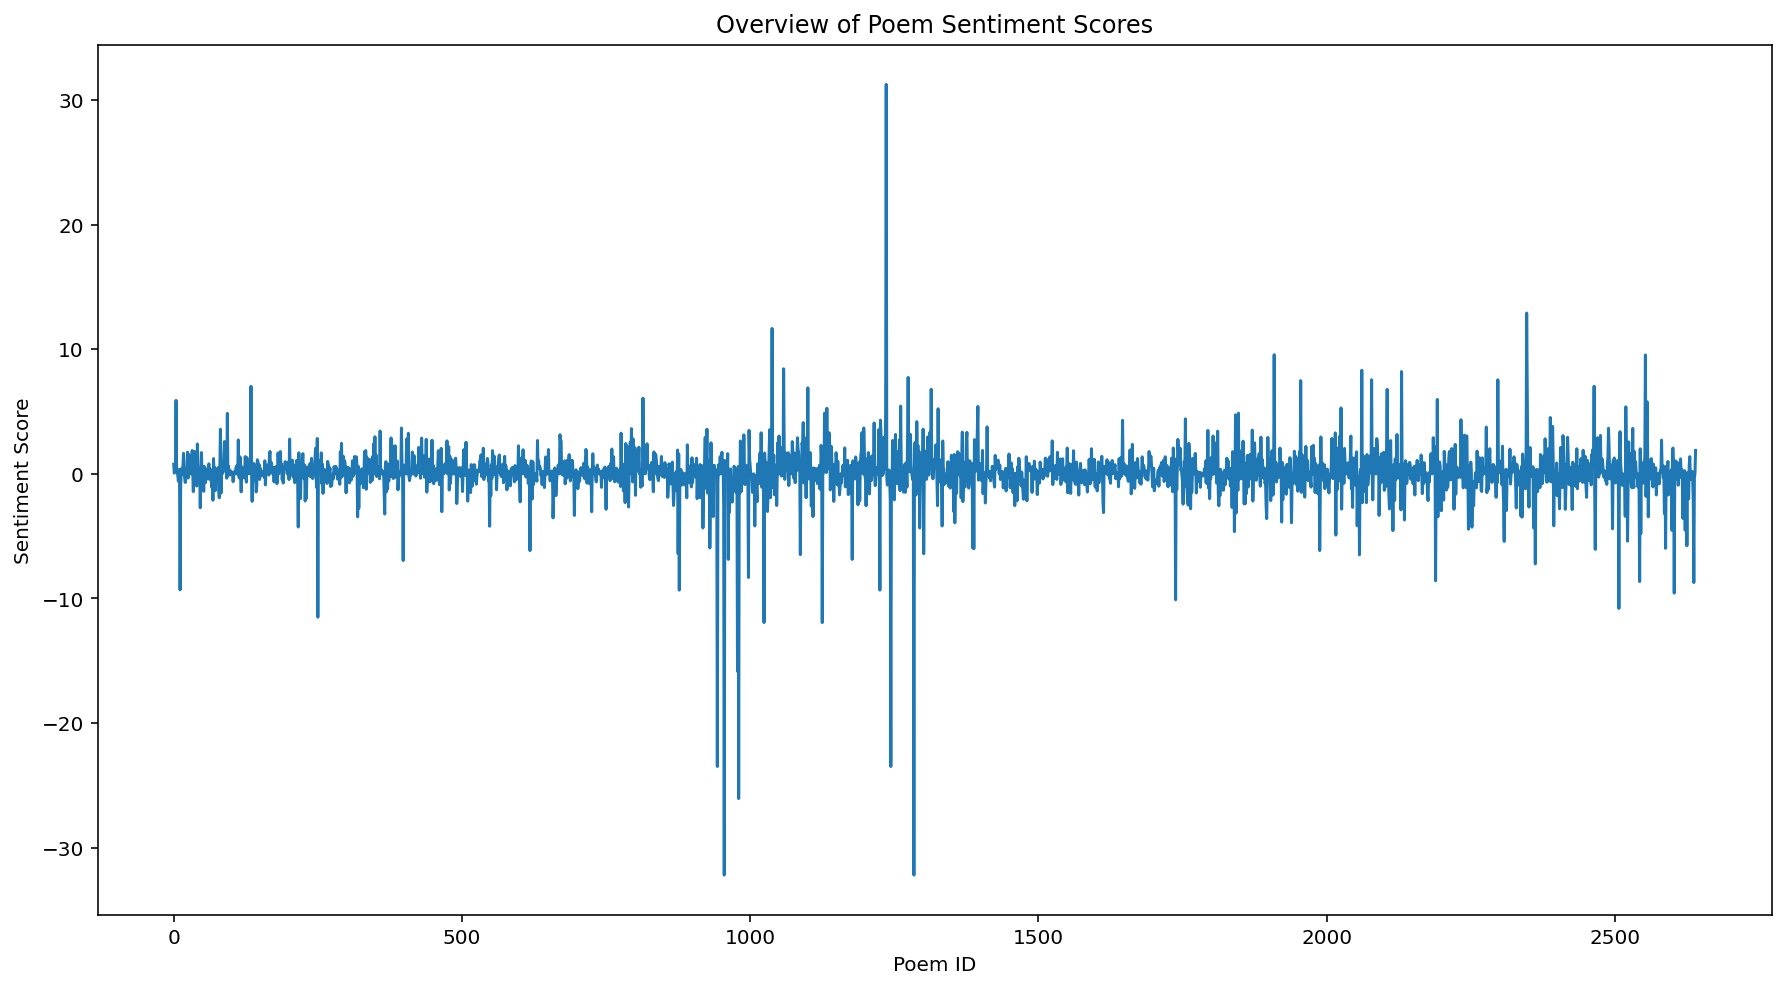

In [92]:
%config InlineBackend.figure_format = 'retina'
plot = poems_df["sent_score"].plot(figsize = (15, 8), ylabel = "Sentiment Score", xlabel = "Poem ID", title = "Overview of Poem Sentiment Scores", fontsize=25)
plot.get_figure().savefig("plot.png")

**Write corpus**

In [93]:
all_poems = []

for filepath in poems_df["file_path"]:
    with open(filepath) as file:
        text = file.read()
        all_poems.append(text)

In [94]:
len(all_poems)

2641

In [ ]:
with open("corpus/DATA/all_poems.txt", "w") as file:
    for poem in all_poems:
        file.write(poem + "\n")

**Train/Test Split**

In [43]:
from sklearn.model_selection import train_test_split

In [44]:
with open("corpus/DATA/all_poems.txt") as file:
    all_poems = file.read().split("\n")

In [45]:
train, test = train_test_split(all_poems, test_size = 0.15)

In [46]:
print("Train dataset length: " + str(len(train)))
print("Test dataset length: " + str(len(test)))

Train dataset length: 2245
Test dataset length: 397


In [47]:
with open("corpus/DATA/train_dataset.txt", "w") as file4:
    for poem in train:
        file4.write(poem + '\n')

In [48]:
with open("corpus/DATA/test_dataset.txt", "w") as file5:
    for poem in test:
        file5.write(poem + "\n")

**Save files**

In [100]:
poems_df.to_csv("corpus/META/poems_df.csv")

In [97]:
sentiment_df.to_csv("corpus/META/SentiWS.csv", index = None)

In [209]:
corpus_meta_df.to_csv("corpus/META/corpus_df.csv")